In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [17]:
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

How to add a semantic layer over graph database?


In [18]:
groq_api_key = os.getenv("GROQ_API_KEY")

In [19]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it")

In [20]:
llm.invoke("Who is Mahesh Babu?")

AIMessage(content='Mahesh Babu is a renowned Indian actor who primarily works in Telugu cinema. \n\nHere\'s some key information about him:\n\n* **Full Name:** Urvasi Mahesh Babu\n* **Born:** August 9, 1975, in Chennai, Tamil Nadu, India\n* **Known For:** His charismatic screen presence, action-packed roles, and romantic dramas.\n\n**Career Highlights:**\n\n* **Debut:**  "Rajakumarudu" (1999)\n* **Breakthrough:** "Murari" (2001)\n* **Notable Films:** "Okkadu," "Pokiri," "Athadu," "Businessman," "Srimanthudu," "Bharat Ane Nenu," "Maharshi," "Sarileru Neekevvaru", "Sarkaru Vaari Paata"\n\n**Awards and Recognition:**\n\n* He has won numerous awards, including several Filmfare Awards South and Nandi Awards.\n\n**Personal Life:**\n\n* Married to Namrata Shirodkar, a former actress.\n* Has two children, Gautam and Sitara.\n\n**Beyond Acting:**\n\n* Mahesh Babu is also a brand ambassador for various products and has his own production house.\n\n\nMahesh Babu is considered one of the biggest s

In [21]:
from langchain_community.graphs import Neo4jGraph

In [22]:
graph = Neo4jGraph(refresh_schema=False)

In [23]:
graph

In [24]:
movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

In [25]:
graph.query(movies_query)

[]

Semantic layer contains various tools to interact with Knowledge graph. Each tool in semantic layer is like a function

Custom tools with Cypher templates

In [26]:
description_query = """
MATCH (m:Movie|Person)
WHERE m.title CONTAINS $candidate OR m.name CONTAINS $candidate
MATCH (m)-[r:ACTED_IN|IN_GENRE]-(t)
WITH m, type(r) as type, collect(coalesce(t.name, t.title)) as names
WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types
WITH m, collect(types) as contexts
WITH m, "type:" + labels(m)[0] + "\ntitle: "+ coalesce(m.title, m.name) 
       + "\nyear: "+coalesce(m.released,"") +"\n" +
       reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context
RETURN context LIMIT 1
"""

Info Tool

In [27]:
def get_information(entity: str) -> str:
    try:
        data= graph.query(description_query, params={"candidate":entity})
        return data[0]["context"]
    except IndexError:
        return "No Info available"

In [29]:
sample_data=graph.query(description_query, params={"candidate":"Casino"})
sample_data

[{'context': 'type:Movie\ntitle: Casino\nyear: 1995-11-22\nACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods\nIN_GENRE: Drama, Crime\n'}]

In [30]:
get_information("Casino")

'type:Movie\ntitle: Casino\nyear: 1995-11-22\nACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods\nIN_GENRE: Drama, Crime\n'

In [31]:
from typing import Optional, Type
from pydantic import BaseModel, Field

from langchain_core.tools import BaseTool

In [32]:
class InfoInput(BaseModel):
    entity: str = Field(description="movie or a person mentioned in the question")

In [33]:
class InfoTool(BaseTool):
    name: str = "Information"
    description: str = ("useful for when you need to answer questions about various actors or movies")
    args_schema: Type[BaseModel] = InfoInput

    def _run(self, entity:str) -> str:
        """Use the tool."""
        return get_information(entity)
    
    def __arun(self, entity:str) -> str:
        """Use the tool asynchronously"""
        return get_information(entity)

In [34]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

In [35]:
tools = [InfoTool()]
llm_with_tools = llm.bind_tools(tools)

In [36]:
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with finding and explaining relevant information about movies."
)

Node

In [37]:
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg]+state["messages"])]}

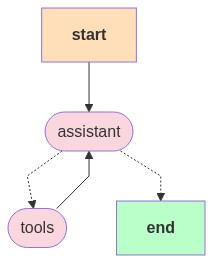

In [38]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
input_messages = [HumanMessage(content="Who played in the Casino?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who played in the Casino?
================================== Ai Message ==================================
Tool Calls:
  Information (28995x9er)
 Call ID: 28995x9er
  Args:
    entity: Casino
================================= Tool Message =================================
Name: Information

type:Movie
title: Casino
year: 1995-11-22
ACTED_IN: Robert De Niro, Joe Pesci, Sharon Stone, James Woods
IN_GENRE: Drama, Crime

================================== Ai Message ==================================

Robert De Niro, Joe Pesci, Sharon Stone, and James Woods


In [40]:
input_messages = [HumanMessage(content="What movies did Brad Pitt act in?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What movies did Brad Pitt act in?
================================== Ai Message ==================================
Tool Calls:
  Information (45qyk26wk)
 Call ID: 45qyk26wk
  Args:
    entity: Brad Pitt
================================= Tool Message =================================
Name: Information

type:Person
title: Brad Pitt
year: 
ACTED_IN: Seven (a.k.a. Se7en), Interview with the Vampire: The Vampire Chronicles, Legends of the Fall

================================== Ai Message ==================================

Seven (a.k.a. Se7en), Interview with the Vampire: The Vampire Chronicles, Legends of the Fall
